In [1]:
!make -C .. regression_df

make: Entering directory '/home/martibosch/data-science/invest-heat-islands'
make: Nothing to be done for 'regression_df'.
make: Leaving directory '/home/martibosch/data-science/invest-heat-islands'


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from shapely import geometry
from sklearn import (ensemble, inspection, linear_model, metrics,
                     model_selection, svm, utils)

from invest_heat_islands import plot_utils

In [3]:
regression_df_filepath = '../data/interim/regression/regression-df.csv'

In [4]:
regression_df = pd.read_csv(regression_df_filepath, index_col=[0, 1])

In [5]:
def make_dataset(regression_df,
                 features=None,
                 target='tair_station',
                 shuffle=True):
    y = regression_df[target]
    if features is None:
        X = regression_df.drop(target, axis=1)
    else:
        X = regression_df[list(features)]

    if shuffle:
        X, y = utils.shuffle(X, y)

    return X, y

In [6]:
regression_df.head()

tair_grid      lst_0    ndwi_0    lst_200  \
2018-05-25 BOURG-EN-LAVAUX  19.461983  26.014134 -0.334515  26.754689   
           BOVDCH           18.861845  21.650461 -0.456614  21.830704   
           BOVDMR           19.510229  26.395785 -0.229706  26.079124   
           BOVDSO           19.251825  21.088022 -0.465147  21.477795   
           MARCELIN         19.318867  24.975926 -0.355455  25.100744   

                            ndwi_200    lst_400  ndwi_400    lst_600  \
2018-05-25 BOURG-EN-LAVAUX -0.266422  26.528556 -0.275616  26.043737   
           BOVDCH          -0.392005  22.426036 -0.401703  22.464239   
           BOVDMR          -0.269882  25.949049 -0.262776  25.356981   
           BOVDSO          -0.417006  22.195320 -0.388652  22.970605   
           MARCELIN        -0.343064  24.344891 -0.371353  24.286819   

                            ndwi_600    lst_800  ndwi_800  elev  tair_station  
2018-05-25 BOURG-EN-LAVAUX -0.260330  25.255805 -0.219232   519     19.400000  
           BOVDCH          -0.406227  22.308259 -0.396235   680     19.560417  
           BOVDMR          -0.217986  24.551374 -0.167194   380     23.209028  
           BOVDSO          -0.376730  23.260748 -0.365749   500     21.593056  
           MARCELIN        -0.371502  24.394364 -0.367017   436     19.900000

After dropping the missing observations, the total number of samples is:

In [7]:
len(regression_df)

92

## Model performance

In [8]:
target = 'tair_station'

model_dict = {
    'lr': linear_model.LinearRegression,
    'svm': svm.SVR,    
    'rf': ensemble.RandomForestRegressor
}

In [9]:
X, y = make_dataset(regression_df, target=target)

model_perf_df = pd.DataFrame(columns=['R^2', 'RMSE'])
for model_label in model_dict:
    model = model_dict[model_label]
    regr = model().fit(X, y)
    model_perf_df.loc[model.__name__] = regr.score(
        X, y), metrics.mean_squared_error(y, regr.predict(X), squared=False)

model_perf_df.style.set_caption('Table 1. Model performance')

,R^2,RMSE
LinearRegression,0.890789,1.068726
SVR,0.044893,3.160518
RandomForestRegressor,0.969852,0.561512


If all the samples are considered, the random forest regressor achieves the best fit with a coefficient of determination of $R^2 = 0.965$, followed by the $R^2 = 0.891$ achieved by the ordinary linear regression.

### Cross validation

In [10]:
num_repetitions = 20
num_folds = 3

In [11]:
accuracy_df = pd.DataFrame(columns=model_dict.keys(),
                           index=range(num_repetitions))

for i in range(num_repetitions):
    X, y = make_dataset(regression_df, target=target)

    for model_label in model_dict:
        accuracy_df.loc[(i, model_label)] = model_selection.cross_val_score(
            model_dict[model_label](), X, y, cv=num_folds).mean()

accuracy_df.mean()

lr     0.813892
svm   -0.039909
rf     0.743702
dtype: float64

The cross validation suggests that the linear regression is more robust to missing data and also less likely to over-fit the observations than the random forest regressor.

## Feature importance

In [12]:
X, y = make_dataset(regression_df, target=target)

for model_label in model_dict:
    model = model_dict[model_label]
    regr = model().fit(X, y)

    importance_df = pd.DataFrame(
        inspection.permutation_importance(regr, X, y),
        index=regression_df.drop(target, axis=1).columns,
        columns=[f'importances_{param}' for param in ('mean', 'std')])
    print(model)
    print(
        importance_df.sort_values(by='importances_mean',
                                  ascending=False).head(10))
    print()

<class 'sklearn.linear_model._base.LinearRegression'>
           importances_mean  importances_std
ndwi_600          36.723776         3.305242
ndwi_400          14.063014         1.254453
lst_400           12.082951         0.769810
ndwi_800           9.301346         0.637346
lst_600            8.464934         0.593380
lst_200            7.288940         0.798787
lst_800            3.852048         0.204043
tair_grid          1.315876         0.078233
ndwi_200           0.519210         0.083719
elev               0.384591         0.021740

<class 'sklearn.svm._classes.SVR'>
           importances_mean  importances_std
elev           1.099056e-01     5.406293e-02
tair_grid      3.020679e-03     2.108997e-04
lst_800        1.633550e-03     1.183254e-04
lst_400        1.628144e-03     1.138571e-04
lst_600        1.623627e-03     1.111472e-04
lst_200        1.573903e-03     1.515572e-04
lst_0          1.567966e-03     1.787411e-04
ndwi_800       1.248838e-08     1.321721e-08
ndwi_600  

The feature importances change dramatically according to the regression model.

In the case of linear regression, the feature importances can be futher assessed by a F-test of significance:

In [13]:
est = sm.OLS(y, sm.add_constant(X))
est.fit().summary(title='Table 2. OLS regression results')

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Table 2. OLS regression results                        
==============================================================================
Dep. Variable:           tair_station   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     53.70
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           6.74e-33
Time:                        22:08:42   Log-Likelihood:                -136.66
No. Observations:                  92   AIC:                             299.3
Df Residuals:                      79   BIC:                             332.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9787      2.270      3.955      0.000       4.459      13.498
tair_grid      0.8141      0.072     11.366      0.000       0.672       0.957
lst_0          0.2482      0.411      0.604      0.548      -0.570       1.067
ndwi_0         2.8126      3.726      0.755      0.453      -4.604      10.229
lst_200       -1.7802      0.627     -2.840      0.006      -3.028      -0.533
ndwi_200     -19.2590     10.760     -1.790      0.077     -40.677       2.159
lst_400        2.3600      1.229      1.920      0.058      -0.087       4.807
ndwi_400      93.3192     31.569      2.956      0.004      30.482     156.156
lst_600       -2.0582      2.042     -1.008      0.316      -6.122       2.006
ndwi_600    -142.8069     37.450     -3.813      0.000    -217.350     -68.264
lst_800        1.3556      1.160      1.169      0.246      -0.954       3.665
ndwi_800      72.3148     15.253      4.741      0.000      41.955     102.674
elev          -0.0122      0.002     -5.902      0.000      -0.016      -0.008
==============================================================================
Omnibus:                        4.536   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.512
Skew:                           0.282   Prob(JB):                        0.105
Kurtosis:                       3.926   Cond. No.                     2.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With a significance level of $p=0.05$, the results of the F-test suggest that the significant variables are the elevation, the LST when spatially averaged with a 200m radius, the NDWI when spatially averaged with a 400m, 600m and 800m radius, and the air temperature from the MeteoSwiss 1 km grids.

The mean squared residuals between the MeteoSwiss 1 km grids and the temperatures observed in the monitoring stations is shown below:

In [14]:
regression_df['sq_err'] = (regression_df['tair_grid'] -
                           regression_df['tair_station'])**2
msr = regression_df['sq_err'].mean()
print('Mean squared residuals:', msr)
print('Root mean squared residuals:', np.sqrt(msr))

Mean squared residuals: 2.262395725608107
Root mean squared residuals: 1.5041262332690388


## Prediction with the chosen model

In [15]:
X, y = make_dataset(regression_df, shuffle=False)

# regr = ensemble.RandomForestRegressor().fit(X, y)
regr = linear_model.LinearRegression().fit(X, y)

y_pred = regr.predict(X)

## Unraveling the error patterns

In [16]:
comparison_df = regression_df.copy()

comparison_df['obs'] = y
comparison_df['pred'] = y_pred
comparison_df['err'] = y_pred - y
# comparison_df['sq_err'] = comparison_df['err']**2

comparison_df['date'] = pd.to_datetime(comparison_df.index.get_level_values(0))
comparison_df['station'] = comparison_df.index.get_level_values(1)

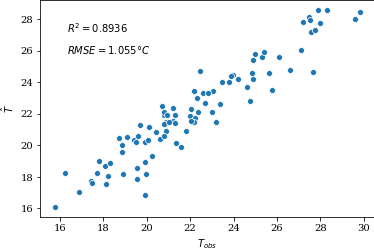

In [17]:
fig = plot_utils.plot_pred_obs(comparison_df, r_sq=regr.score(X, y))
fig.savefig('../reports/figures/spatial-regression-pred-obs.pdf')

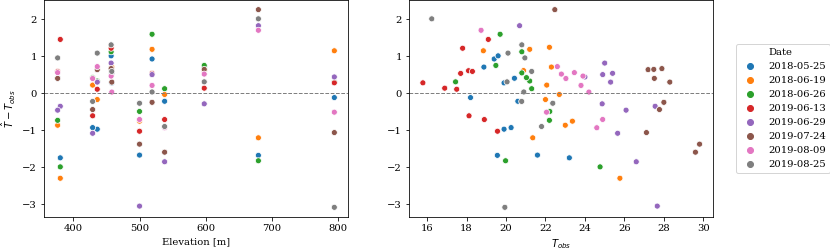

In [18]:
fig = plot_utils.plot_err_elev_obs(comparison_df)
fig.savefig('../reports/figures/spatial-regression-errors.pdf')

### Plotting the maps predicted by the spatial regression

In [19]:
!make -C .. tair_regr_maps

make: Entering directory '/home/martibosch/data-science/invest-heat-islands'
make: Nothing to be done for 'tair_regr_maps'.
make: Leaving directory '/home/martibosch/data-science/invest-heat-islands'


In [20]:
tair_regr_filepath = '../data/processed/tair-regr-maps.nc'
station_locations_filepath = '../data/raw/stations/station-locations.csv'

In [21]:
T_regr_da = xr.open_dataarray(tair_regr_filepath)
station_location_df = pd.read_csv(station_locations_filepath, index_col='stn')

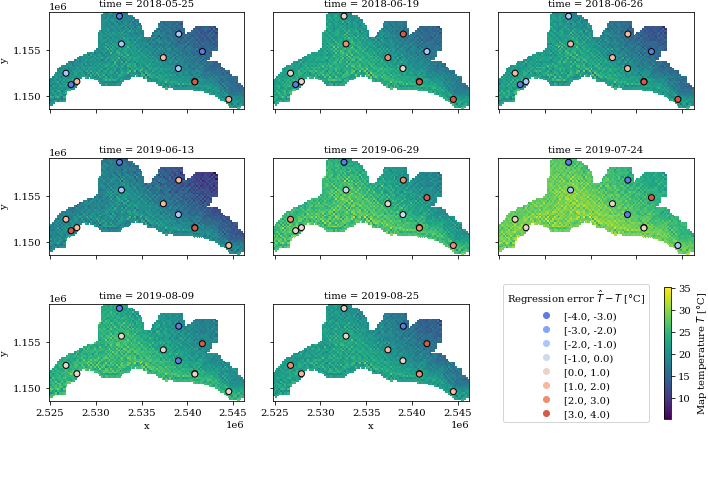

In [22]:
g = plot_utils.plot_T_maps(T_regr_da,
                           station_location_df,
                           comparison_df=comparison_df)
g.fig.savefig('../reports/figures/spatial-regression-maps.png')